# Present data for report



In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

from cartopy import crs as ccrs
from scipy import stats

from config import DATA_SRC, POP_DATA_SRC, WEATHER_SRC

In [2]:
# Figure settings
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.dpi'] = 600
plt.rcParams['figure.figsize'] = (5,2.5)
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['axes.titlesize'] = 'medium'
plt.rcParams['savefig.bbox'] = 'tight'

In [3]:
MAX_YEAR = 2021
REFERENCE_YEAR_START = 1986
REFERENCE_YEAR_END = 2005

RESULTS_FOLDER = Path('../results/heatwaves/').absolute()

INTERMEDIATE_RESULTS_FOLDER = DATA_SRC / 'lancet'/ 'heatwaves'/ 'results_2022'
SD_FOLDER = Path('~').expanduser() / 'Documents' / 'Lancet'/ 'Standardisation guidelines - LIVE FOR AUTHORS'
COUNTRY_SHAPEFILE = SD_FOLDER / 'Shapefiles' / 'detailed_2013.shp'

COUNTRY_ID_LOOKUP = DATA_SRC/ 'lancet/population/gpwv4/gpw_v4_national_identifier_lookup.txt'
COUNTRY_RASTER_FILES = DATA_SRC/ 'lancet/population/country_codes_30min_era_compat.nc'

In [4]:
MAP_PROJECTION = ccrs.EckertIII()

In [5]:
MIN_YEAR = 1980

In [6]:
COUNTRIES_LOOKUP = pd.read_csv(COUNTRY_ID_LOOKUP,sep='\t')

## Load basic country data

In [12]:
countries = gpd.read_file(COUNTRY_SHAPEFILE)

In [13]:
country_classification = pd.read_excel(SD_FOLDER / 'Country names - ISO3 codes - WHO and HDI classifications2021.xlsx', skiprows=1)

countries = countries.set_index('ISO_3_CODE')

countries = countries.join(country_classification.set_index('ISO ALPHA-3 code'))

countries.index.name = 'country'

In [10]:
countries.plot(column='Level of human development')

<AxesSubplot:>

In [9]:
un_pop_totals = pd.read_csv(POP_DATA_SRC / 'UN' / 'WPP2019_TotalPopulationBySex.csv')
un_pop_totals = un_pop_totals[un_pop_totals.VarID == 2] # medium variant 

un_pop_totals = un_pop_totals.set_index('LocID').join(COUNTRIES_LOOKUP.set_index('UNSDCODE')['ISOCODE'])

un_pop_totals = un_pop_totals[~pd.isna(un_pop_totals.ISOCODE)]

In [10]:
un_pop_totals_xr = un_pop_totals[['ISOCODE', 'Time', 'PopTotal']].set_index(['ISOCODE', 'Time']).sort_index().to_xarray()

un_pop_totals_xr = un_pop_totals_xr.rename({'Time': 'year', 'ISOCODE': 'country'}).PopTotal

## Load exposure results

In [18]:
exposures_over65 = xr.open_dataset(INTERMEDIATE_RESULTS_FOLDER / f'heatwave_exposure_change_over65_multi_threshold_{MIN_YEAR}-{MAX_YEAR}.nc')

In [19]:
exposures_infants = xr.open_dataset(
    INTERMEDIATE_RESULTS_FOLDER / f'heatwave_exposure_change_infants_multi_threshold_{MIN_YEAR}-{MAX_YEAR}.nc')


In [20]:
exposures = xr.concat([exposures_infants, exposures_over65], dim='age_band_lower_bound')

In [59]:
total_exposures = exposures.sum(['latitude', 'longitude'])

In [64]:
total_exposures_over65 = total_exposures.sel(age_band_lower_bound=65, drop=True).to_dataframe()

In [65]:
total_exposures_infants = total_exposures.sel(age_band_lower_bound=0, drop=True).to_dataframe()

## Load weighted results

In [23]:
# weighted_metrics_over65 = pd.read_excel(RESULTS_FOLDER / 'heatwave_metrics_weighted_mean_over65.xlsx').set_index('year')

# weighted_metrics_infants = pd.read_excel(RESULTS_FOLDER / 'heatwave_metrics_weighted_infants.xlsx').set_index('year')

## Load the country exposure results

In [24]:
country_exposure = xr.open_dataset(
    INTERMEDIATE_RESULTS_FOLDER / f'countries_heatwaves_exposure_change_{MIN_YEAR}-{MAX_YEAR}.nc')

## Load country weighted mean heatwave

In [7]:
country_weighted = xr.open_dataset(INTERMEDIATE_RESULTS_FOLDER / f'countries_heatwaves_exposure_weighted_change_{MIN_YEAR}-{MAX_YEAR}.nc')

In [32]:
# # Create DF merging the country normalised data with the country data
# cw_df = country_weighted.heatwaves_days.to_dataframe().heatwaves_days.unstack()
# cw_df = countries.join(cw_df)
# cw_df = cw_df.join(country_weighted[ 'heatwaves_days'].sel(year=slice(2000,2020)).mean(dim='year').to_dataframe())

## Load aggregated by hdi and WHO region data

In [10]:
hdi_exposure = xr.open_dataset(INTERMEDIATE_RESULTS_FOLDER / f'hdi_regions_heatwaves_exposure_change_{MIN_YEAR}-{MAX_YEAR}.nc')

who_exposure = xr.open_dataset(INTERMEDIATE_RESULTS_FOLDER / f'who_regions_heatwaves_exposure_change_{MIN_YEAR}-{MAX_YEAR}.nc')

## Load heatwave metrics files

In [34]:
hwd_mean = heatwave_metrics_delta.heatwaves_days.mean(dim=['latitude', 'longitude'])

NameError: name 'heatwave_metrics_delta' is not defined

# Re-export data tables as csv

In [14]:
country_weighted = xr.merge([
    country_weighted,
    countries.loc[~pd.isna(countries.index),
               ['WHO_REGION','WHO Region', 'Level of human development', 'Human Development Index in 2018 (HDI)']]
          .to_xarray()
         ])

In [16]:
(country_weighted
 .heatwaves_days
 .to_dataframe()
 .unstack(level='age_band_lower_bound')
 .to_csv(RESULTS_FOLDER / 'heatwave_exposure_wieghted_change_days_by_country_w_hdi.csv')
)

In [36]:
(country_exposure
 .heatwaves_days
 .to_dataframe()
 .unstack(level='age_band_lower_bound')
 .to_csv(RESULTS_FOLDER / 'heatwave_exposure_days_by_country.csv')
)

In [37]:
(who_exposure
 .heatwaves_days
 .to_dataframe()
 .unstack(level='age_band_lower_bound')
 .to_csv(RESULTS_FOLDER / 'heatwave_exposure_days_by_who_region.csv')
)

In [38]:
(hdi_exposure
 .heatwaves_days
 .to_dataframe()
 .unstack(level='age_band_lower_bound')
 .to_csv(RESULTS_FOLDER / 'heatwave_exposure_days_by_hdi.csv')
)

### Create country table with the WHO and HDI region columns

In [47]:
country_exposure = xr.merge([
    country_exposure,
    countries.loc[~pd.isna(countries.index),
               ['WHO_REGION','WHO Region', 'Level of human development', 'Human Development Index in 2018 (HDI)']]
          .to_xarray()
         ])

In [49]:
country_exposure.to_netcdf(RESULTS_FOLDER / 'heatwave_exposure_days_by_country_w_hdi_who.nc')

In [53]:
country_exposure.sel(age_band_lower_bound=0, drop=True).to_dataframe()

heatwaves_days WHO_REGION WHO Region Level of human development  \
country year                                                                    
ABW     1980   -2.771695e+03       AMRO        NaN                        NaN   
        1981   -7.148474e+02       AMRO        NaN                        NaN   
        1982   -2.800953e+03       AMRO        NaN                        NaN   
        1983   -4.194150e+02       AMRO        NaN                        NaN   
        1984   -2.792662e+03       AMRO        NaN                        NaN   
...                      ...        ...        ...                        ...   
ZWE     2017   -1.031929e+06       AFRO    African                     Medium   
        2018   -7.171716e+05       AFRO    African                     Medium   
        2019    6.385945e+06       AFRO    African                     Medium   
        2020    3.497185e+06       AFRO    African                     Medium   
        2021    4.890801e+06       AFRO    African                     Medium   

              Human Development Index in 2018 (HDI)  
country year                                         
ABW     1980                                    NaN  
        1981                                    NaN  
        1982                                    NaN  
        1983                                    NaN  
        1984                                    NaN  
...                                             ...  
ZWE     2017                                 0.5631  
        2018                                 0.5631  
        2019                                 0.5631  
        2020                                 0.5631  
        2021                                 0.5631  

[10542 rows x 5 columns]

In [54]:
(country_exposure
 .sel(age_band_lower_bound=65, drop=True)
 .to_dataframe()
 .to_csv(RESULTS_FOLDER / 'heatwave_exposure_days_by_country_over65_w_hdi_who.csv')
)
(country_exposure
 .sel(age_band_lower_bound=0, drop=True)
 .to_dataframe()
 .to_csv(RESULTS_FOLDER / 'heatwave_exposure_days_by_country_infants_w_hdi_who.csv'))

# Plots

## Plot exposures

**NOTE** Some of this is already saved out automatically in the data gen notebook

> Plot exposures combining the 1980-2000 values calculated using histsoc with the 2000-2020 values. Highlight that the data sources are different

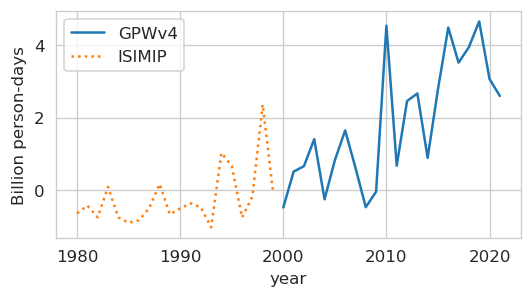

In [66]:
with sns.axes_style("whitegrid"):
    var = 'heatwaves_days'

    f, ax = plt.subplots()

    (total_exposures_over65[var] / 1e9).loc[2000:].plot(ax=ax, label='GPWv4')
    (total_exposures_over65[var] / 1e9).loc[:1999].plot(style=':', label='ISIMIP', ax=ax)
    ax.legend()
    ax.set_ylabel('Billion person-days')
    f.savefig(RESULTS_FOLDER / 'heatwave person-days hybrid 1980-2020.png')
    f.savefig(RESULTS_FOLDER / 'heatwave person-days hybrid 1980-2020.pdf')
    
    

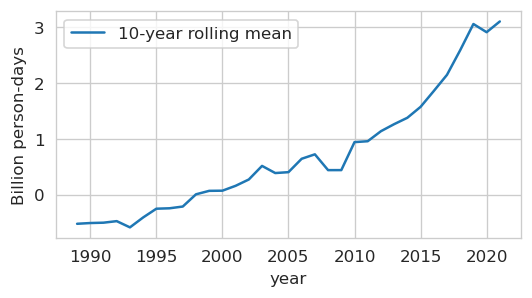

In [67]:
plot_data  = (total_exposures_over65[var] / 1e9).rolling(10).mean()
with sns.axes_style("whitegrid"):
    var = 'heatwaves_days'

    f, ax = plt.subplots()

    plot_data.plot(ax=ax, label='10-year rolling mean')
#     (total_exposures_over65[var] / 1e9).loc[:1999].rolling(10).mean().plot(style=':', label='ISIMIP', ax=ax)
    ax.legend()
    ax.set_ylabel('Billion person-days')
#     f.savefig(RESULTS_FOLDER / 'heatwave person-days hybrid 1980-2020.png')
#     f.savefig(RESULTS_FOLDER / 'heatwave person-days hybrid 1980-2020.pdf')
    
    

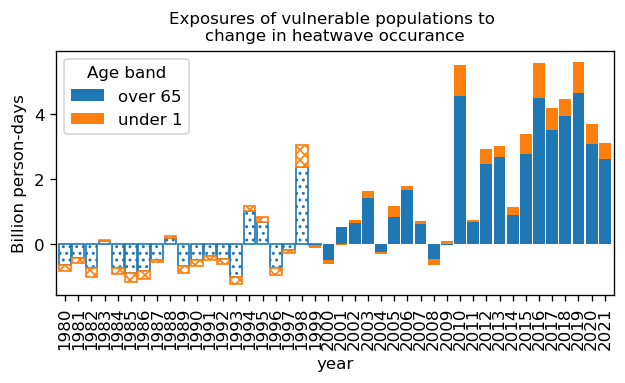

In [70]:

f , ax = plt.subplots(figsize=(6,2.7))
plot_data = pd.concat([total_exposures_over65.heatwaves_days, total_exposures_infants.heatwaves_days], axis=1) / 1e9
plot_data.columns = ['over 65', 'under 1']
ax = plot_data.plot.bar(stacked=True, width=0.89, ax=ax)
ax.set_ylabel('Billion person-days')
ax.set_title('Exposures of vulnerable populations to \nchange in heatwave occurance')
ax.legend(title='Age band')

# NOTE: wasn't an easy way to set the different hatches so have to set manually the indexes
for p in ax.patches[:20]:
    p.set_hatch('...')
    p.set_edgecolor('C0')
    p.set_facecolor('w')

for p in ax.patches[42:61]:
    p.set_hatch('xxxx')
    p.set_edgecolor('C1')
    p.set_facecolor('w')

plt.savefig(RESULTS_FOLDER / f'heatwave person-days hybrid w newborn 1980-{MAX_YEAR}.png')
plt.savefig(RESULTS_FOLDER / f'heatwave person-days hybrid w newborn 1980-{MAX_YEAR}.pdf')

In [71]:
sns.color_palette("Paired")

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

In [72]:
_namelookup = COUNTRIES_LOOKUP.set_index('ISOCODE').NAME0.to_dict()
_namelookup['Other'] = 'Rest of World'

In [73]:
c = sns.color_palette("Paired")

In [88]:
consistent_colors = dict(zip(
    ['CHN', 'EGY', 'IDN', 'IND', 'JPN', 'NGA', 'Other', 'USA'],
    [c[5], c[6],   c[7], c[3], c[8], c[11], c[0], c[1] ]
))

In [78]:
top_codes = (country_exposure[var]
             .sel(year=slice(2015,2020), age_band_lower_bound=65, drop=True)
             .mean(dim='year')
             .to_dataframe()
             .sort_values(by=var, ascending=False)
             .head(5)[var].index.to_list()
            )

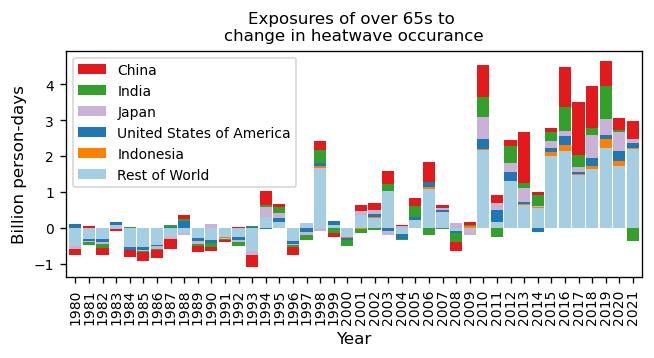

In [81]:
var = 'heatwaves_days'
age_band = 65
# Sort and show the top 5 for a given year
top_codes = (country_exposure[var]
             .sel(year=slice(2015,2020), age_band_lower_bound=age_band, drop=True)
             .mean(dim='year')
             .to_dataframe()
             .sort_values(by=var, ascending=False)
             .head(5)[var].index.to_list()
            )

results = (country_exposure[var]
           .sel(country=top_codes, age_band_lower_bound=age_band, drop=True)
           .to_dataframe()[var]
           .unstack().T)
# Difference between sum of top5 countries and total gives the 'other' category
results['Other'] = total_exposures_over65[var] - results.sum(axis=1)
# invert column order
results = results[results.columns[::-1]]

f, ax = plt.subplots(figsize=(6.2, 2.5))
(results / 1e9).plot.bar(stacked=True, 
                         width=0.9, 
                         ax=ax,
                         color=consistent_colors
                        )

ax.set(
    xlabel='Year',
    ylabel='Billion person-days',
    title='Exposures of over 65s to \nchange in heatwave occurance',
)
ax.xaxis.set_tick_params(labelsize='small')
ax.yaxis.set_tick_params(labelsize='small')

# Manually order the legend
handles, labels = ax.get_legend_handles_labels()
d = dict(zip(labels, handles))
iso_codes = ['CHN', 'IND', 'JPN', 'USA', 'IDN', 'Other']


ordered_handles = [d[l] for l in iso_codes]
ordered_labels = [_namelookup[l] for l in iso_codes]

ordered_handles = [d[l] for l in iso_codes]
ax.legend(ordered_handles, ordered_labels, fontsize='small')

f.savefig(RESULTS_FOLDER / f'hw_exposure_over65_countries_1980-{MAX_YEAR}.png')
f.savefig(RESULTS_FOLDER / f'hw_exposure_over65_countries_1980-{MAX_YEAR}.pdf')


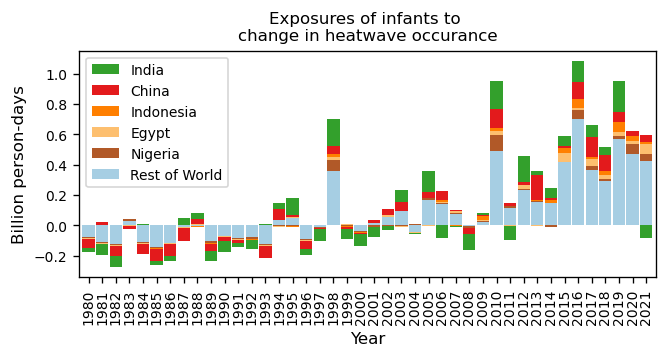

In [82]:
# Sort and show the top 5 for a given year
var = 'heatwaves_days'
age_band = 0
# Sort and show the top 5 for a given year
top_codes = (country_exposure[var]
             .sel(year=slice(2015,2020), age_band_lower_bound=age_band, drop=True)
             .mean(dim='year')
             .to_dataframe()
             .sort_values(by=var, ascending=False)
             .head(5)[var].index.to_list()
            )

results = (country_exposure[var]
           .sel(country=top_codes, age_band_lower_bound=age_band, drop=True)
           .to_dataframe()[var]
           .unstack().T)

# Difference between sum of top5 countries and total gives the 'other' category
results['Other'] = total_exposures_infants[var] - results.sum(axis=1)
# invert column order
results = results[results.columns[::-1]]

f, ax = plt.subplots(figsize=(6.2, 2.5))
(results / 1e9).plot.bar(stacked=True,
                         width=0.9, 
                         ax=ax,
                         color=consistent_colors
                        )

ax.set(
    xlabel='Year',
    ylabel='Billion person-days',
    title='Exposures of infants to \nchange in heatwave occurance',
)
ax.xaxis.set_tick_params(labelsize='small')
ax.yaxis.set_tick_params(labelsize='small')

# Manually order the legend
handles, labels = ax.get_legend_handles_labels()
d = dict(zip(labels, handles))
iso_codes = ['IND','CHN', 'IDN',  'EGY', 'NGA', 'Other']

ordered_handles = [d[l] for l in iso_codes]
ordered_labels = [_namelookup[l] for l in iso_codes]

ax.legend(ordered_handles, ordered_labels, fontsize='small')

f.savefig(RESULTS_FOLDER / f'hw_exposure_infants_countries_1980-{MAX_YEAR}.png')
f.savefig(RESULTS_FOLDER / f'hw_exposure_infants_countries_1980-{MAX_YEAR}.pdf')


In [84]:
country_exposure_allages = country_exposure.sum('age_band_lower_bound')

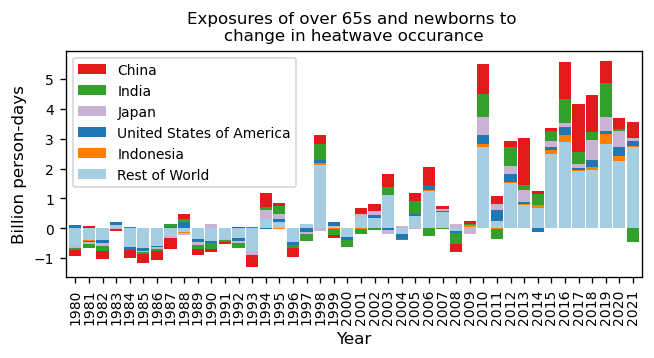

In [89]:
var = 'heatwaves_days'
# Sort and show the top 5 for a given year
top_codes = (country_exposure_allages[var]
             .sel(year=slice(2015,2020))
             .mean(dim='year')
             .to_dataframe()
             .sort_values(by=var, ascending=False)
             .head(5)[var]
             .index
             .to_list()
)
results = (country_exposure_allages[var]
           .sel(country=top_codes)
           .to_dataframe()[var]
           .unstack()
           .T)
# Difference between sum of top5 countries and total gives the 'other' category
results['Other'] = (total_exposures_over65[var] + total_exposures_infants[var] ) - results.sum(axis=1)
# invert column order
results = results[results.columns[::-1]]

# with sns.color_palette("Paired"):
f, ax = plt.subplots(figsize=(6.2, 2.5))
(results / 1e9).plot.bar(stacked=True, 
                         width=0.9, 
                         ax=ax,
                         color=consistent_colors
                        )

ax.set(
    xlabel='Year',
    ylabel='Billion person-days',
    title='Exposures of over 65s and newborns to \nchange in heatwave occurance',
)
ax.xaxis.set_tick_params(labelsize='small')
ax.yaxis.set_tick_params(labelsize='small')

# Manually order the legend
handles, labels = ax.get_legend_handles_labels()
d = dict(zip(labels, handles))
iso_codes = ['CHN', 'IND', 'JPN', 'USA', 'IDN', 'Other']

ordered_handles = [d[l] for l in iso_codes]
ordered_labels = [_namelookup[l] for l in iso_codes]

ax.legend(ordered_handles, ordered_labels, fontsize='small')

f.savefig(RESULTS_FOLDER / f'hw_exposure_over65_newborn_countries_1980-{MAX_YEAR}.png')
f.savefig(RESULTS_FOLDER / f'hw_exposure_over65_newborn_countries_1980-{MAX_YEAR}.pdf')


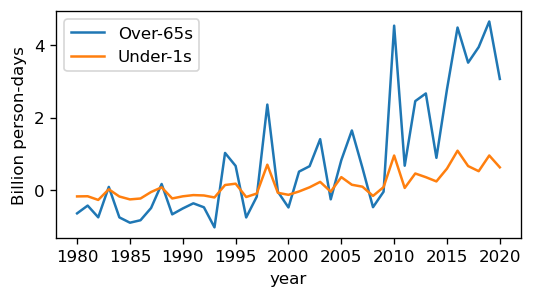

In [46]:
(total_exposures_over65.heatwaves_days / 1e9).plot(label='Over-65s')
ax = (total_exposures_infants.heatwaves_days/ 1e9).plot(label='Under-1s')
ax.set_ylabel('Billion person-days')
ax.legend()
plt.savefig(RESULTS_FOLDER / 'old newborn time series.png')
plt.savefig(RESULTS_FOLDER / 'old newborn time series.pdf')

## HDI and WHO plots for appendix

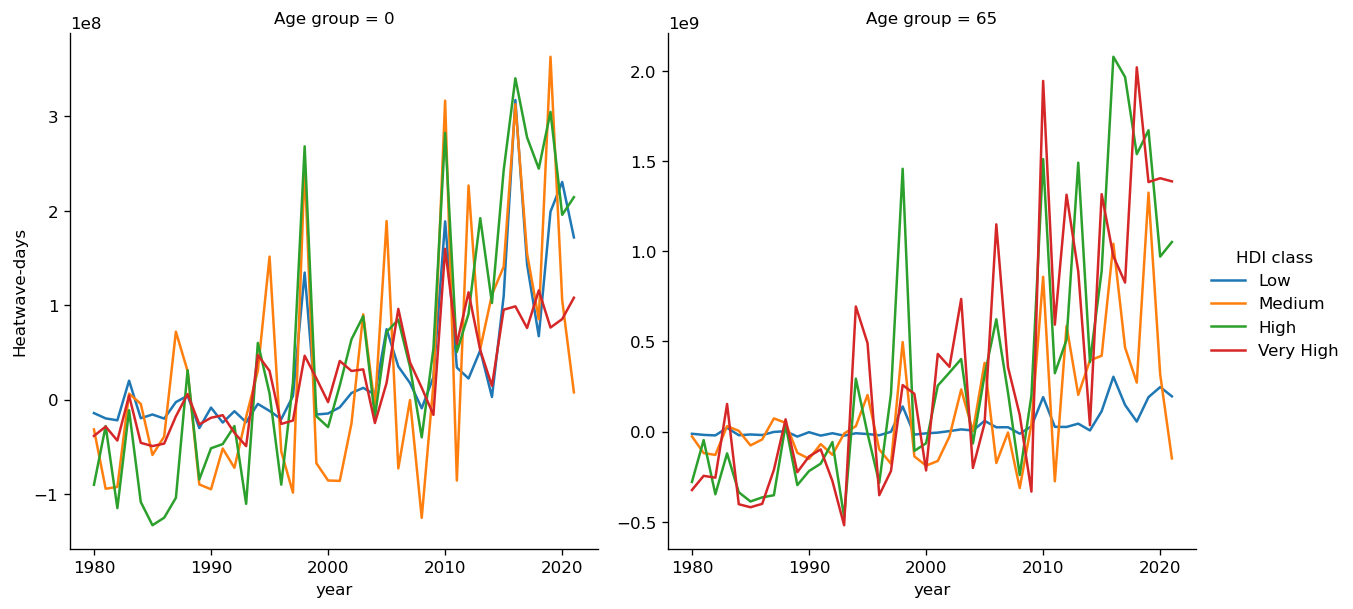

In [25]:
plot_data = hdi_exposure.heatwaves_days.to_dataframe().reset_index()
plot_data = plot_data.rename(columns={'age_band_lower_bound': 'Age group',
                                      'heatwaves_days': 'Heatwave-days',
                                      'level_of_human_development':'HDI class'})
# plot_data[plot_data.age_band_lower_bound ==0]
sns.relplot(kind='line', data=plot_data,
            x='year', y='Heatwave-days', col='Age group', hue='HDI class',
           facet_kws={'sharey':False})
plt.savefig(RESULTS_FOLDER / 'heatwaves_by_hdi.png')

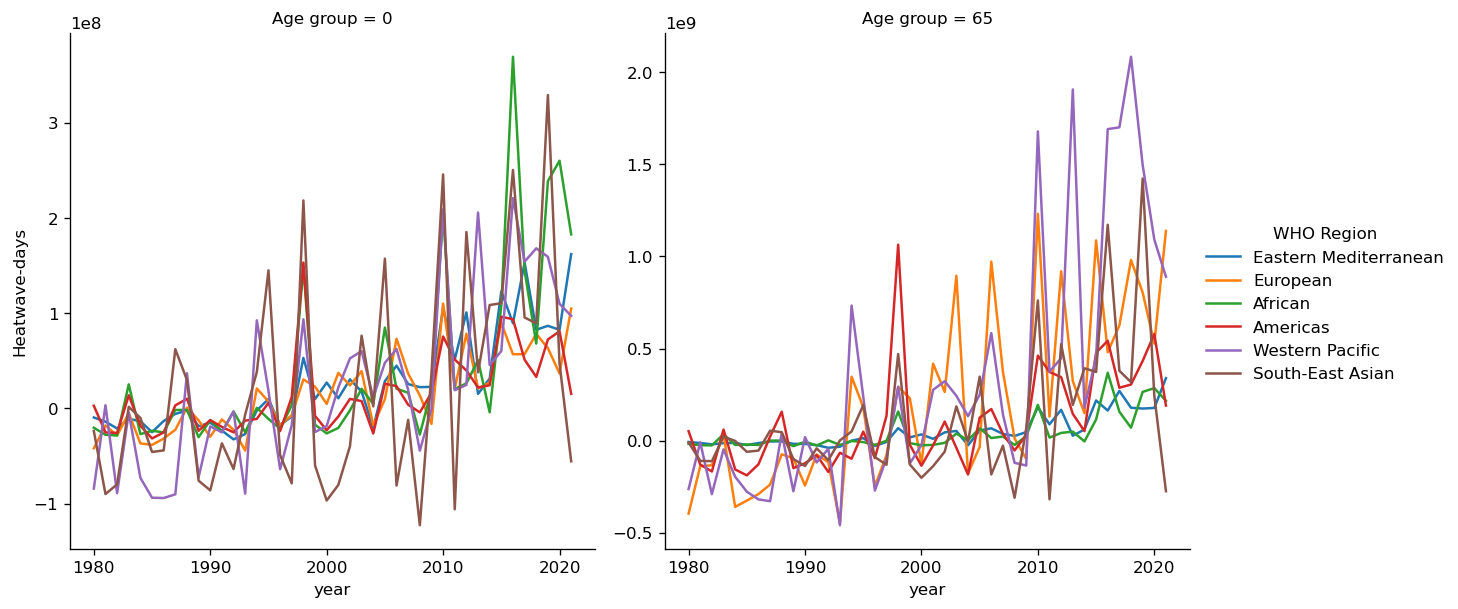

In [24]:
plot_data = who_exposure.heatwaves_days.to_dataframe().reset_index()
plot_data = plot_data.rename(columns={'age_band_lower_bound': 'Age group',
                                      'heatwaves_days': 'Heatwave-days',
                                      'who_region':'WHO Region'})
# plot_data[plot_data.age_band_lower_bound ==0]
sns.relplot(kind='line', data=plot_data,
            x='year', y='Heatwave-days', col='Age group', hue='WHO Region',
           facet_kws={'sharey':False})
plt.savefig(RESULTS_FOLDER / 'heatwaves_by_who_region.png')